# Setup

## Imports

In [1]:
from fastai.structured import *

In [81]:
import feather
import scipy.cluster.hierarchy as hc
import treeinterpreter.treeinterpreter as ti

from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from pdpbox import pdp
from plotnine import *

## Define Useful Features

In [3]:
jtplot_style()

In [4]:
COMPETITION = 'bluebook-for-bulldozers'

In [5]:
DIR_DATA = DIR_KAGGLE / COMPETITION

In [6]:
_rmse = lambda input_, target: ((input_ - target) ** 2).mean()

In [7]:
def _eval(self, x, y):
    return self.score(x, y), _rmse(self.predict(x), y)

RandomForestRegressor.eval = _eval

In [8]:
def split_val(*args, frac):
    assert np.std([len(a) for a in args]) == 0

    n_train = int(len(args[0]) * (1- frac))
    return [a[:n_train] for a in args], [a[n_train:] for a in args]

In [9]:
def _print_scores(model):
    print('Training - r^2, RMSE:', model.eval(x, y))
    print('Validation - r^2, RMSE:', model.eval(x_val, y_val))
    if hasattr(model, 'oob_score_'): print('oob:', model.oob_score_)

In [10]:
def train_model(self):
    self.fit(x, y)
    _print_scores(self)
    return self

In [11]:
RandomForestRegressor.train = train_model

## Load Data

In [12]:
data = feather.read_dataframe(DIR_DATA / 'train.ft')

In [13]:
x, y, nas = proc_df(data.copy(), 'SalePrice') # Need copy() to preserve the DF for later

In [14]:
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)

# Feature Importance

## Find Most Important Features

In [15]:
set_rf_samples(50000)

In [16]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.9119633192211599, 0.042222963308626245)
Validation - r^2, RMSE: (0.879441006987372, 0.06308514935786698)


In [17]:
fi = rf_feat_importance(model, x)
fi[:10]

cols       imp
5             YearMade  0.168942
37      Coupler_System  0.110019
13         ProductSize  0.104028
14  fiProductClassDesc  0.075098
2              ModelID  0.059666
38      Grouser_Tracks  0.052995
63         saleElapsed  0.050164
10     fiSecondaryDesc  0.039420
8          fiModelDesc  0.034470
39     Hydraulics_Flow  0.031474

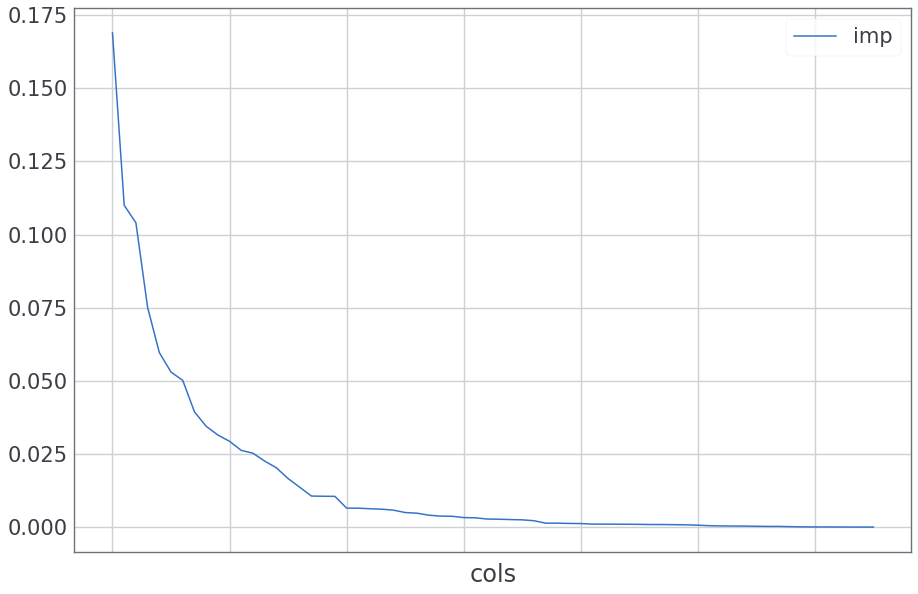

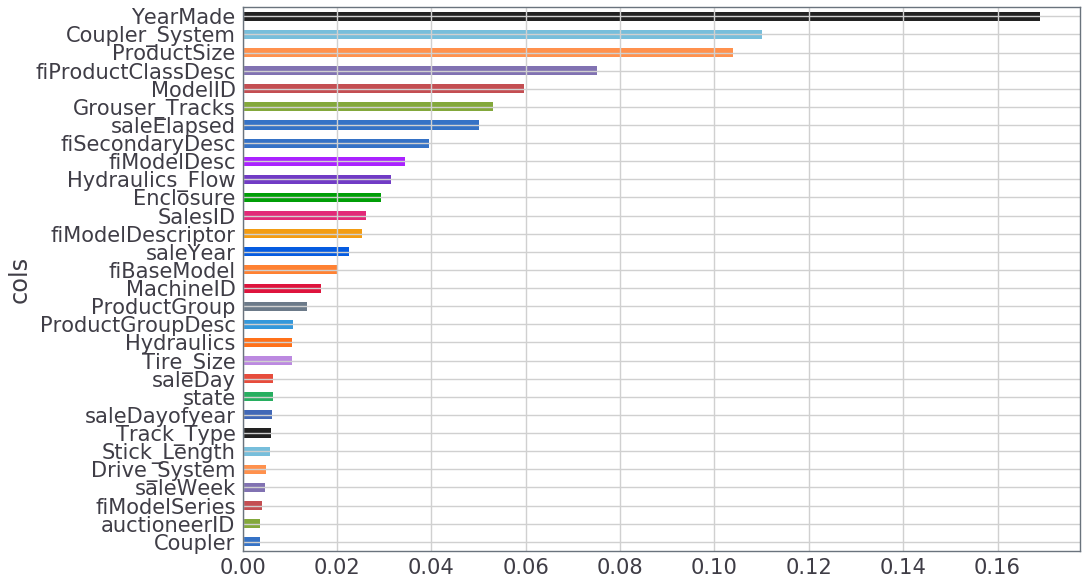

In [18]:
fi.plot('cols', 'imp')
fi[:30][::-1].plot('cols', 'imp', 'barh', legend=False)

## Reduce Features

In [19]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

25

In [23]:
x = x[to_keep]; x_val = x_val[to_keep]

In [24]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.910144954610197, 0.04309506277411233)
Validation - r^2, RMSE: (0.8798693432839975, 0.06286101295316773)


In [25]:
fi = rf_feat_importance(model, x)
fi[:10]

cols       imp
0             YearMade  0.171547
1       Coupler_System  0.097855
2          ProductSize  0.090239
3   fiProductClassDesc  0.085544
5              ModelID  0.062380
4       Grouser_Tracks  0.053278
6          saleElapsed  0.053018
9      Hydraulics_Flow  0.051488
7      fiSecondaryDesc  0.042348
10         fiModelDesc  0.036155

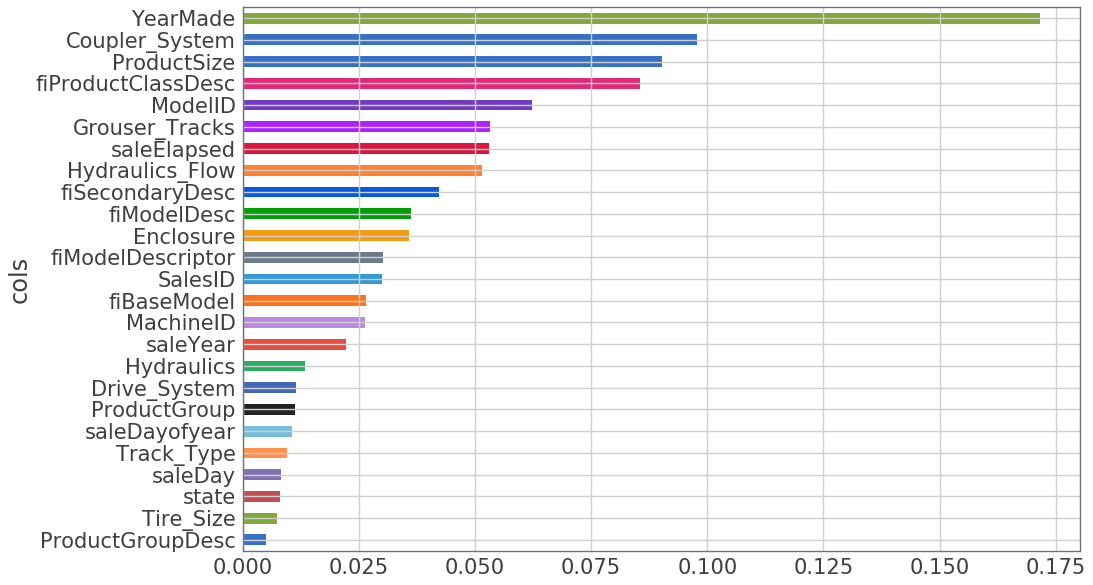

In [26]:
fi[::-1].plot('cols', 'imp', 'barh', legend=False)

## One-Hot Encoding

In [30]:
x, y, nas = proc_df(data.copy(), 'SalePrice', max_n_cat=7)
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)

In [31]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.909566460938973, 0.04337251209226335)
Validation - r^2, RMSE: (0.8749100602111685, 0.06545606708840415)


In [32]:
fi = rf_feat_importance(model, x)
fi[:10]

cols       imp
67                  Enclosure_EROPS w AC  0.187660
5                               YearMade  0.136793
55   ProductGroupDesc_Skid Steer Loaders  0.080341
12                    fiProductClassDesc  0.057823
2                                ModelID  0.056001
32                           saleElapsed  0.048628
48                      ProductGroup_SSL  0.045526
43                      ProductSize_Mini  0.040171
9                        fiSecondaryDesc  0.039367
128                   Coupler_System_nan  0.029177

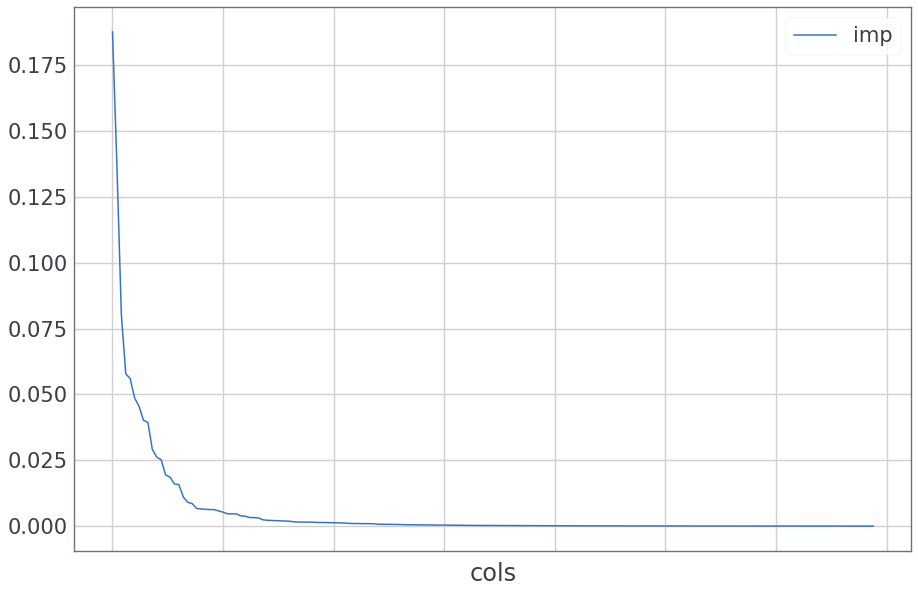

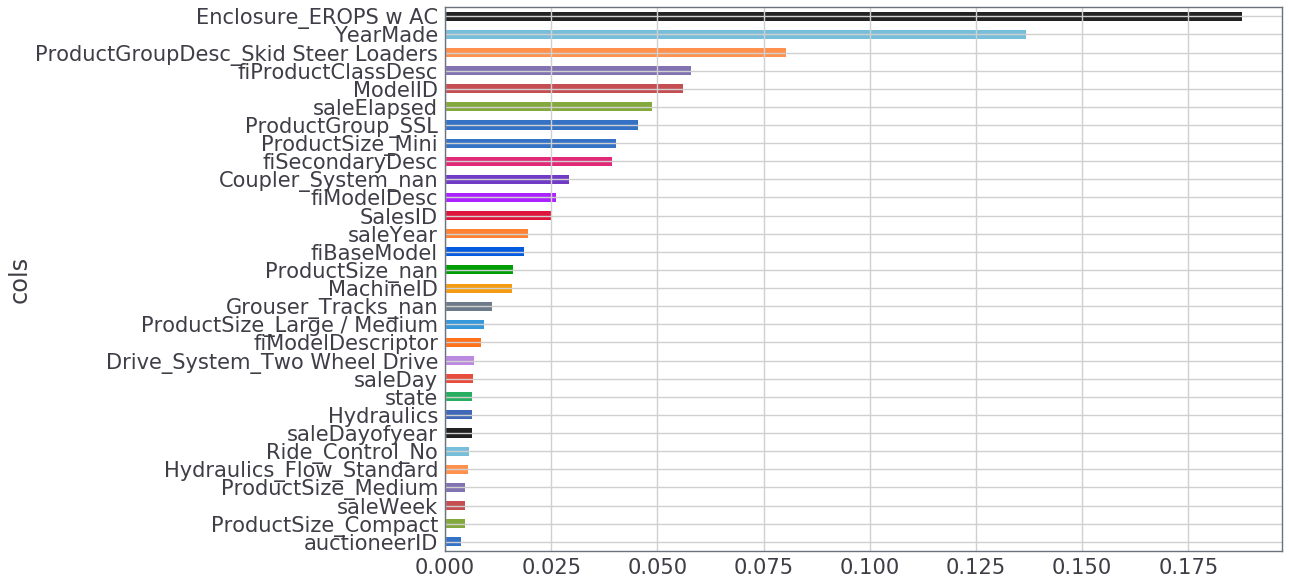

In [33]:
fi.plot('cols', 'imp')
fi[:30][::-1].plot('cols', 'imp', 'barh', legend=False)

## Remove Redundant Features

In [20]:
x, y, nas = proc_df(data.copy(), 'SalePrice')
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)
x = x[to_keep]; x_val = x_val[to_keep]

In [21]:
corr = np.round(spearmanr(x).correlation, 4)

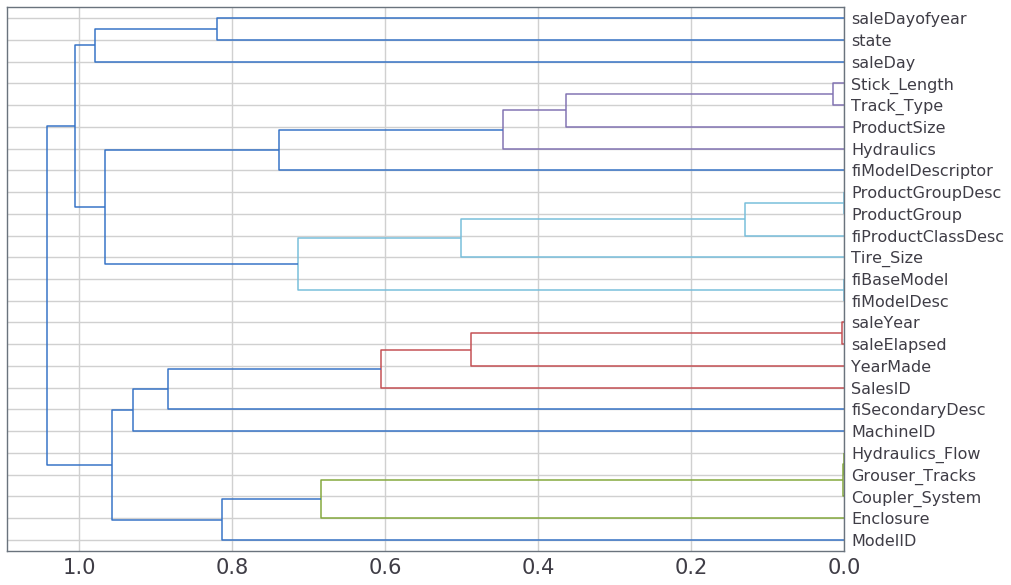

In [25]:
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method='average')
hc.dendrogram(z, labels=x.columns, orientation='left', leaf_font_size=16)
plt.show()

Baseline

In [26]:
RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.9093797605939887, 0.043462054789082806)
Validation - r^2, RMSE: (0.880956512288836, 0.06229212781790204)


In [33]:
for cols in (('saleYear', 'saleElapsed'), ('fiModelDesc', 'fiBaseModel'),
             ('Grouser_Tracks', 'Coupler_System')):
    for c in cols:
        print(c)
        x, y, nas = proc_df(data.copy(), 'SalePrice')
        (x, y), (x_val, y_val) = split_val(x, y, frac=0.03)
        x = x[to_keep]; x_val = x_val[to_keep]
        x.drop(c, axis=1, inplace=True); x_val.drop(c, axis=1, inplace=True)
        RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()
    print('\n')

saleYear
Training - r^2, RMSE: (0.9090997177180414, 0.04359636516938518)
Validation - r^2, RMSE: (0.8825804088080658, 0.06144238818506856)
saleElapsed
Training - r^2, RMSE: (0.907095114355193, 0.04455778594864561)
Validation - r^2, RMSE: (0.8803094337441587, 0.06263072592342012)


fiModelDesc
Training - r^2, RMSE: (0.9088069543325972, 0.043736776388576676)
Validation - r^2, RMSE: (0.8775569503010737, 0.06407102353020155)
fiBaseModel
Training - r^2, RMSE: (0.9093887812944544, 0.043457728402610564)
Validation - r^2, RMSE: (0.8805774440467056, 0.06249048362756879)


Grouser_Tracks
Training - r^2, RMSE: (0.9097893797243355, 0.04326559879644276)
Validation - r^2, RMSE: (0.8830195238051596, 0.061212611587863154)
Coupler_System
Training - r^2, RMSE: (0.9098152208180358, 0.04325320524023972)
Validation - r^2, RMSE: (0.8818535475292952, 0.06182273436404573)




In [35]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
x, y, nas = proc_df(data.copy(), 'SalePrice')
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)
x = x[to_keep]; x_val = x_val[to_keep]
x.drop(to_drop, axis=1, inplace=True); x_val.drop(to_drop, axis=1, inplace=True) 
RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.9084022928450973, 0.04393085466354067)
Validation - r^2, RMSE: (0.8798310466464043, 0.06288105251257427)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Partial Dependence

In [39]:
x, y, nas = proc_df(data.copy(), 'SalePrice', max_n_cat=7) # Need copy() to preserve the DF for later
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)

In [40]:
model = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                              n_jobs=-1, max_features=0.5).train()

Training - r^2, RMSE: (0.9094780075497103, 0.043414934911664455)
Validation - r^2, RMSE: (0.8752146834158585, 0.065296666284818)


In [41]:
fi = rf_feat_importance(model, x)

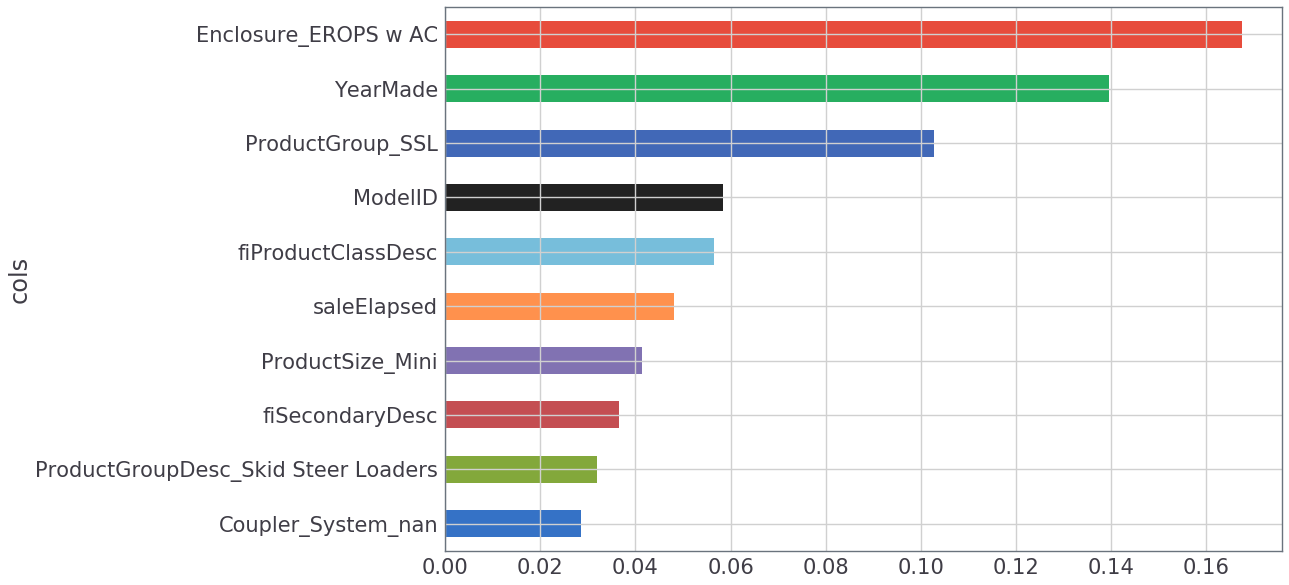

In [42]:
fi[:10][::-1].plot('cols', 'imp', 'barh', legend=False)

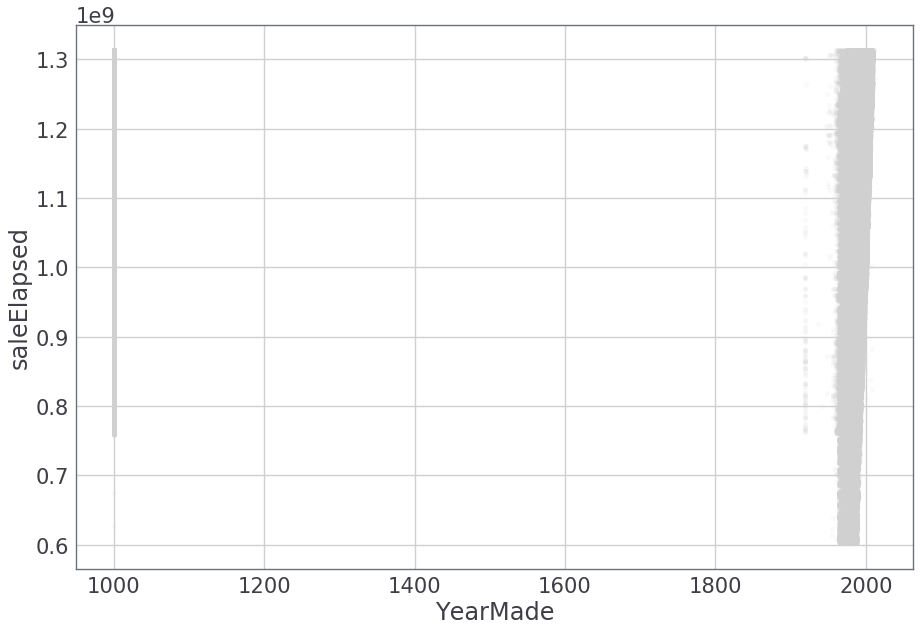

In [43]:
x.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.1)

In [62]:
x_all = get_sample(data[data.YearMade > 1930], 500)

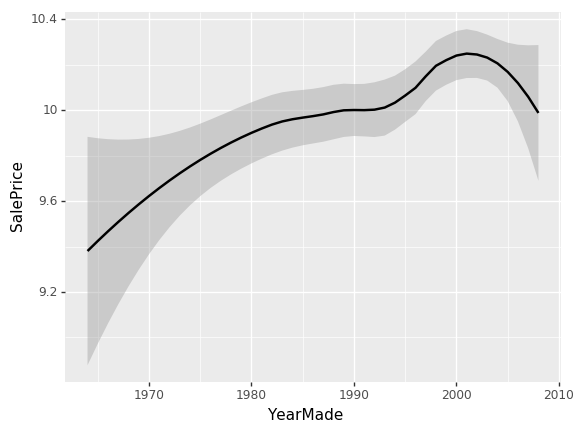

<ggplot: (8756083631887)>

In [63]:
ggplot(x_all, aes('YearMade', 'SalePrice')) + stat_smooth(se=True, method='loess')

In [64]:
x_all = get_sample(x[x.YearMade > 1930], 500)

In [67]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model, x_all, x_all.columns, feat)
    pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

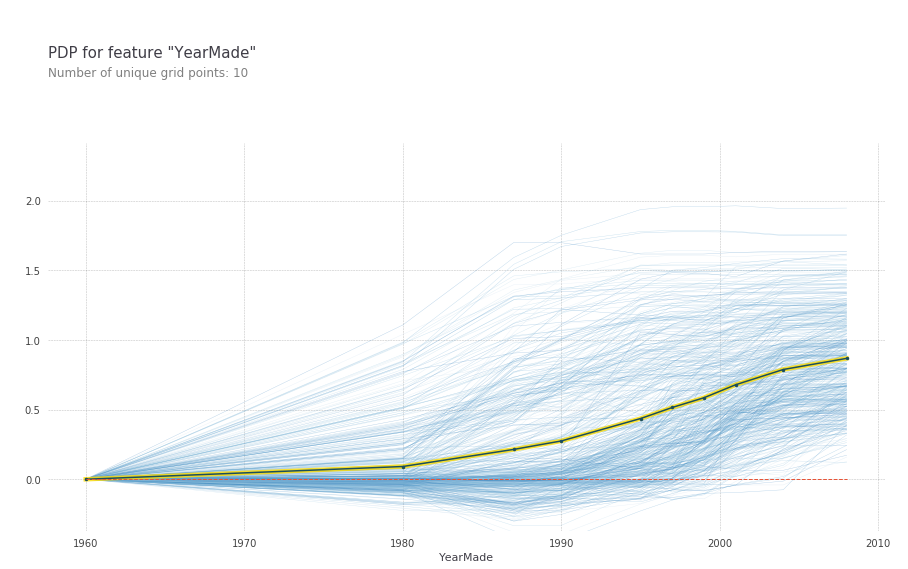

In [68]:
plot_pdp('YearMade')

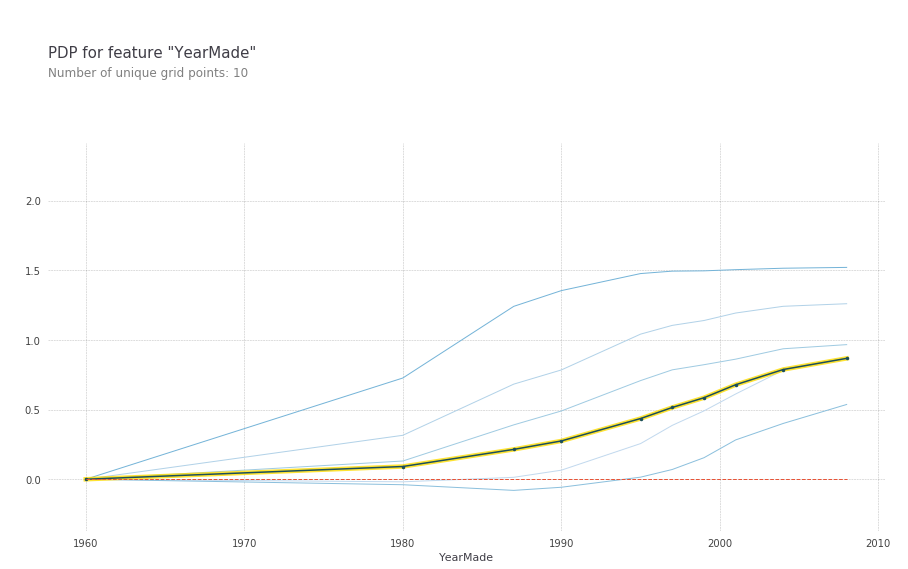

In [69]:
plot_pdp('YearMade', clusters=5)

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(model, x_all, x_all.columns, feats)
pdp.pdp_interact_plot(p, feats)

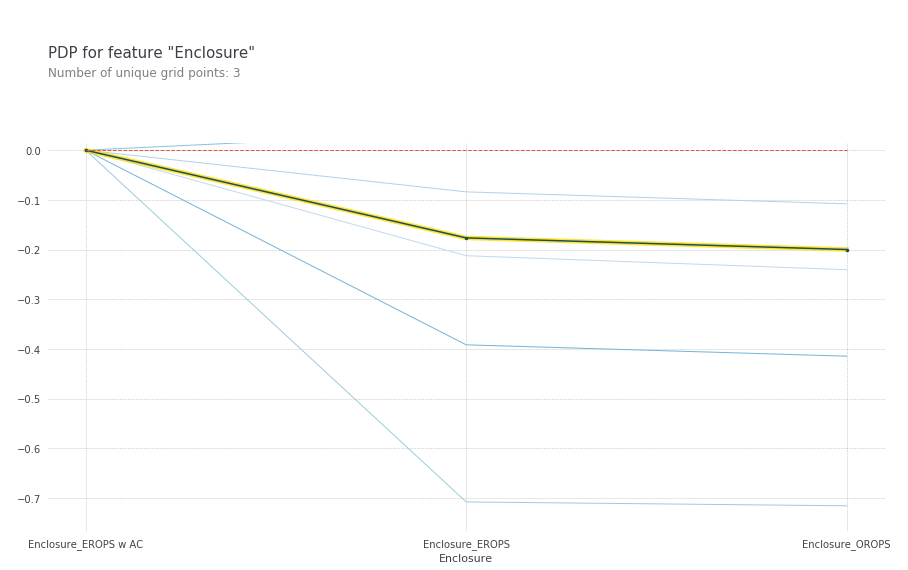

In [71]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [72]:
data['age'] = data.saleYear - data.YearMade

# Tree Interpreter

In [84]:
row = x_val.values[None, 0]

In [85]:
prediction, bias, contributions = ti.predict(model, row)

In [87]:
prediction[0], bias[0]

(array([11.00319]), 10.101241005897434)

In [88]:
idxs = np.argsort(contributions[0])

In [90]:
[o for o in zip(x.columns[idxs], x_val.iloc[0][idxs], contributions[0][idxs])]

[('fiSecondaryDesc', 21, -0.07272772486063235),
 ('fiModelSeries', 0, -0.03644666508151122),
 ('MachineID', 1941822, -0.028073769762965252),
 ('saleElapsed', 1313712000, -0.012182927507540863),
 ('saleYear', 2011, -0.010528289394178224),
 ('fiBaseModel', 774, -0.007547916118723208),
 ('saleDay', 19, -0.006928596733153114),
 ('saleDayofyear', 231, -0.006158283586016155),
 ('saleWeek', 33, -0.005963790988347739),
 ('fiModelDesc', 2491, -0.0049561110363691265),
 ('Pattern_Changer_None or Unspecified', 1, -0.004590214260479364),
 ('ProductGroup_MG', 0, -0.004101727791022869),
 ('Blade_Extension_nan', 1, -0.0037064076223405793),
 ('state', 28, -0.003442296210284468),
 ('saleMonth', 8, -0.0030539981611576116),
 ('UsageBand_Medium', 0, -0.0023982862587307975),
 ('ProductSize_Medium', 0, -0.0022908983776688705),
 ('ProductGroupDesc_Motor Graders', 0, -0.0017600935882603253),
 ('Thumb_nan', 0, -0.001517088079677853),
 ('Grouser_Type_Triple', 0, -0.0015137565898970973),
 ('Travel_Controls_Differ

In [91]:
contributions.sum()

0.9019533706372715

# Confidence Based On Tree Variance

In [26]:
def get_preds(tree): return tree.predict(x_val)

In [27]:
%time preds = np.stack(list(map(get_preds, model.estimators_)))
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 203 ms, sys: 0 ns, total: 203 ms
Wall time: 204 ms


(10.969358143822229, 0.1499169229752669)

In [28]:
%time preds = np.stack(parallel_trees(model, get_preds))

CPU times: user 112 ms, sys: 74.5 ms, total: 186 ms
Wall time: 640 ms


In [29]:
data_val,  = split_val(data.copy(), frac=0.03)[1]
data_val = data_val.copy()
data_val['SalePrice'] = y_val
data_val['pred'] = preds.mean(axis=0)
data_val['pred_std'] = preds.std(axis=0)

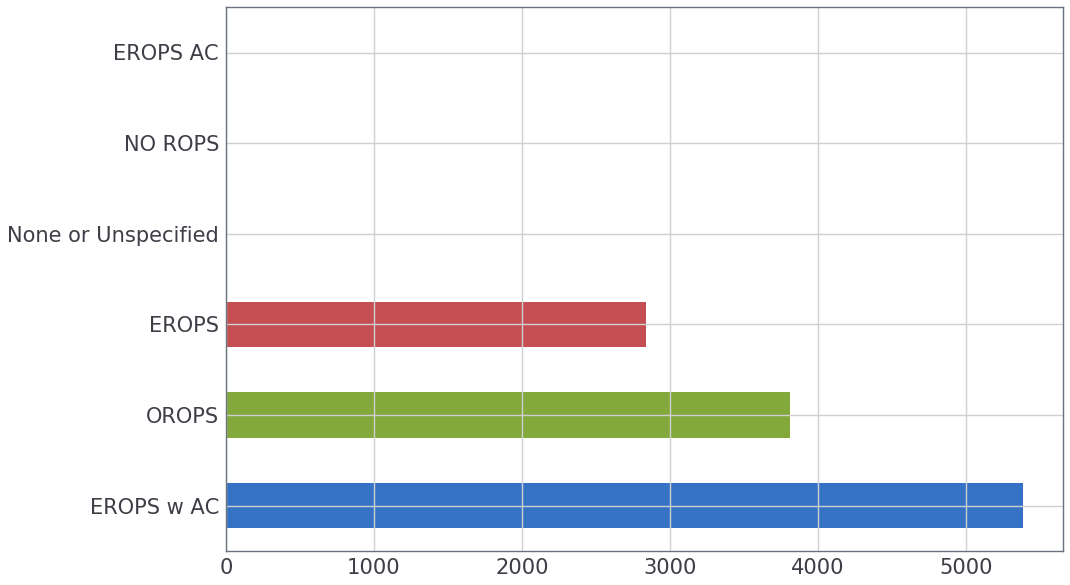

In [30]:
data_val.Enclosure.value_counts().plot.barh()

In [31]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = data_val[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

Enclosure  SalePrice       pred  pred_std
0                EROPS   9.888236   9.878190  0.270736
1             EROPS AC        NaN        NaN       NaN
2           EROPS w AC  10.615275  10.558699  0.250693
3              NO ROPS        NaN        NaN       NaN
4  None or Unspecified        NaN        NaN       NaN
5                OROPS   9.787547   9.777102  0.218935

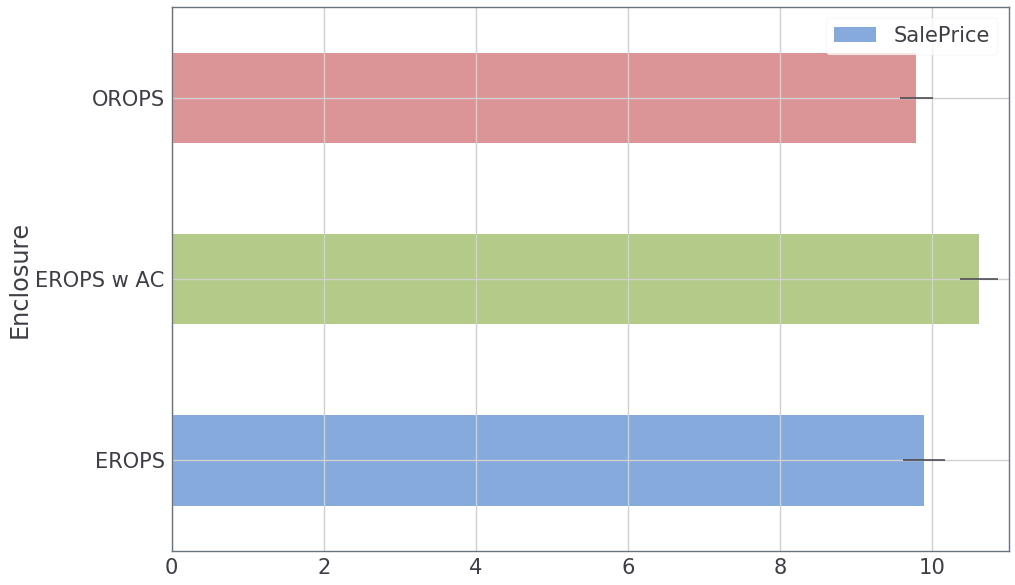

In [32]:
enc_summ = enc_summ[~enc_summ.SalePrice.isnull()]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xerr='pred_std', alpha=0.6, xlim=(0, 11))

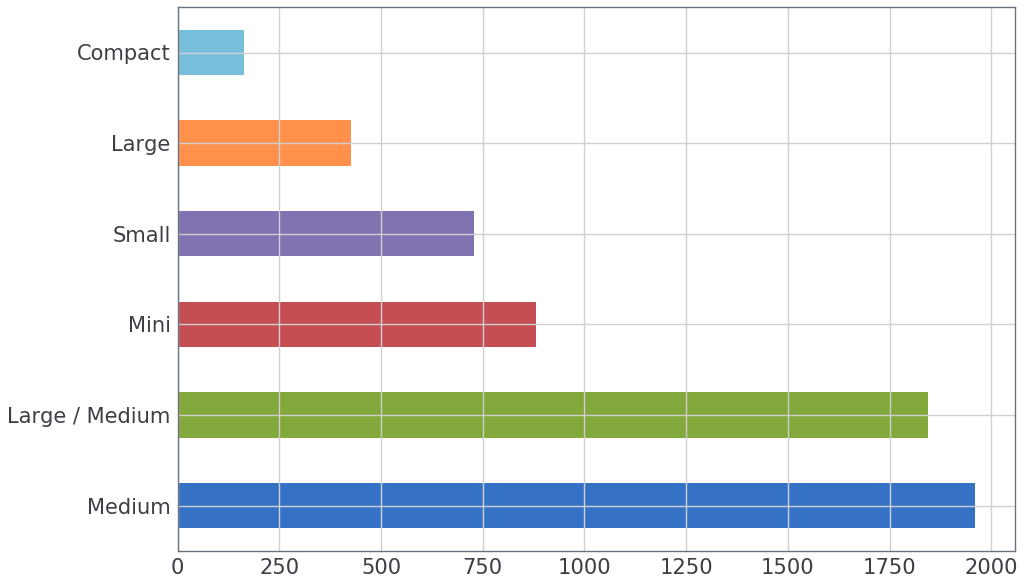

In [33]:
data_val.ProductSize.value_counts().plot.barh()

In [34]:
flds[0] = 'ProductSize'
size_summ = data_val[flds].groupby(flds[0]).mean().sort_values('pred_std', ascending=False)
size_summ

SalePrice       pred  pred_std
ProductSize                                   
Large           10.487875  10.372698  0.357869
Compact          9.670200   9.731178  0.295747
Small           10.376032  10.325340  0.293987
Medium          10.704070  10.650299  0.277541
Large / Medium  10.699743  10.659942  0.270796
Mini             9.620329   9.638328  0.245945

In [35]:
(size_summ.pred_std / size_summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034501
Compact           0.030392
Small             0.028472
Medium            0.026059
Mini              0.025517
Large / Medium    0.025403
dtype: float64

# Exploration

## YearMade

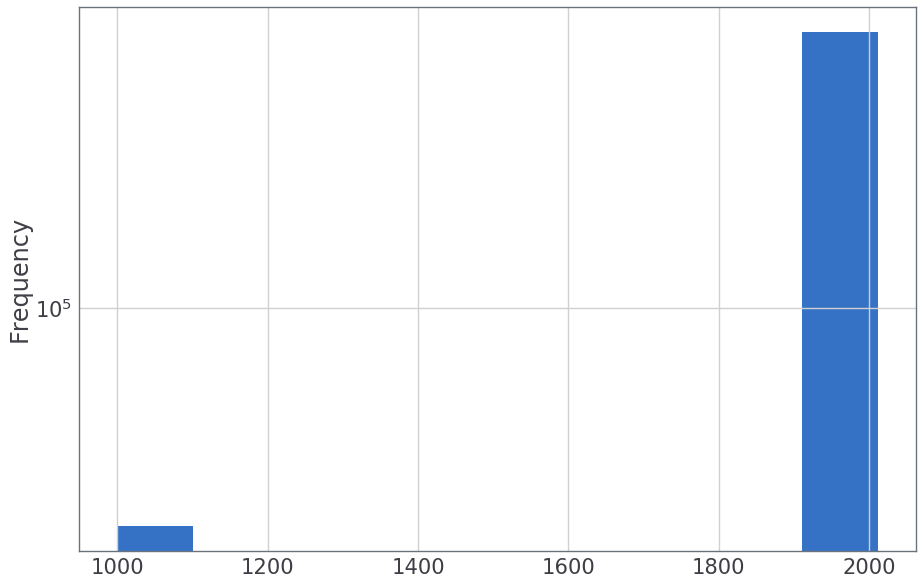

In [36]:
x.YearMade.plot('hist', logy=True)

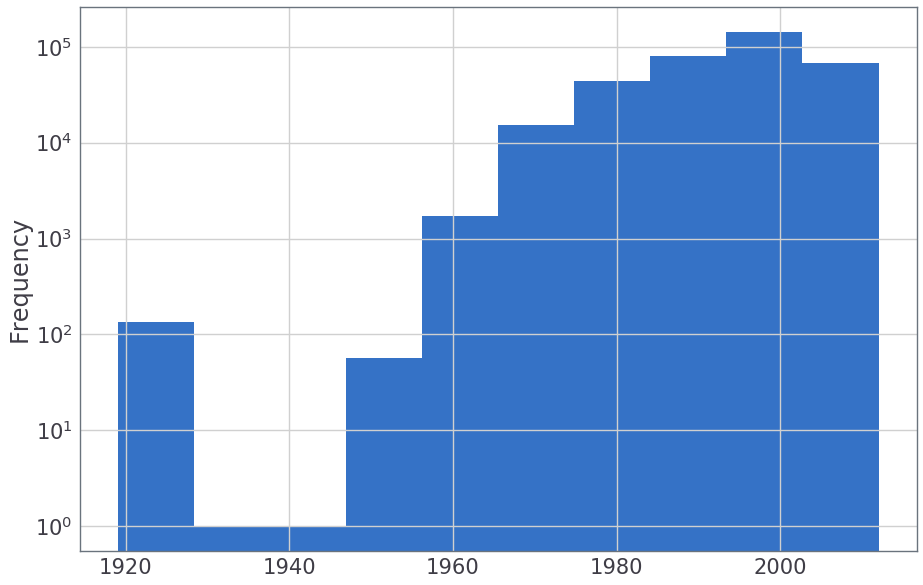

In [37]:
x.YearMade[x.YearMade > 1800].plot('hist', logy=True)

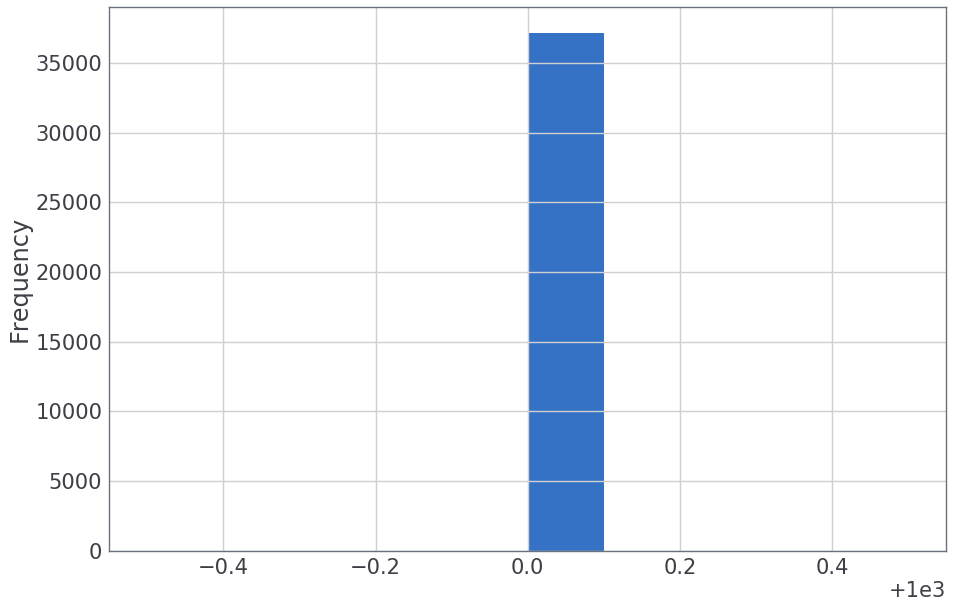

In [38]:
x.YearMade[x.YearMade < 1800].plot('hist')

In [39]:
x.YearMade[x.YearMade < 1800].describe()

count    37145.0
mean      1000.0
std          0.0
min       1000.0
25%       1000.0
50%       1000.0
75%       1000.0
max       1000.0
Name: YearMade, dtype: float64

In [40]:
# By what factor does the cardinality reduce when YearMade is 1000?
(x.nunique() / x[x.YearMade == 1000].nunique()).sort_values(ascending=False)

YearMade              71.000000
SalesID               10.474923
MachineID              9.669867
fiModelDescriptor      1.635294
ModelID                1.541729
fiModelDesc            1.540718
fiSecondaryDesc        1.539823
saleElapsed            1.408638
fiBaseModel            1.314752
Enclosure              1.166667
saleYear               1.150000
state                  1.019231
saleDayofyear          1.014085
saleDay                1.000000
Grouser_Tracks         1.000000
ProductGroup           1.000000
Drive_System           1.000000
Hydraulics             1.000000
Hydraulics_Flow        1.000000
fiProductClassDesc     1.000000
Coupler_System         1.000000
ProductSize            1.000000
ProductGroupDesc       1.000000
dtype: float64

Seems like SalesID and MachineID are strongly correlated with this particular YearMade.

Still, the cardinality is too high.

In [41]:
x[x.YearMade == 1000].nunique().sort_values(ascending=False)

SalesID               37145
MachineID             34368
ModelID                3343
fiModelDesc            3205
saleElapsed            2709
fiBaseModel            1471
saleDayofyear           355
fiSecondaryDesc         113
fiModelDescriptor        85
fiProductClassDesc       74
state                    52
saleDay                  31
saleYear                 20
Hydraulics               13
ProductSize               7
ProductGroupDesc          6
Enclosure                 6
ProductGroup              6
Drive_System              5
Hydraulics_Flow           4
Grouser_Tracks            3
Coupler_System            3
YearMade                  1
dtype: int64

It simply seems too random and uncorrelated for the YearMade to be 1000.
<br><br>
Hypothesis: **It's just an imputed value.**

Let's look at it's impact on the SalePrice

In [59]:
data = feather.read_dataframe(DIR_DATA / 'train.ft')

In [60]:
price_year = [(x, data[data.YearMade == x].SalePrice.median())
              for x in np.sort(data.YearMade.unique())]
price_year = price_year[1:] # Drop YearMade == 1000

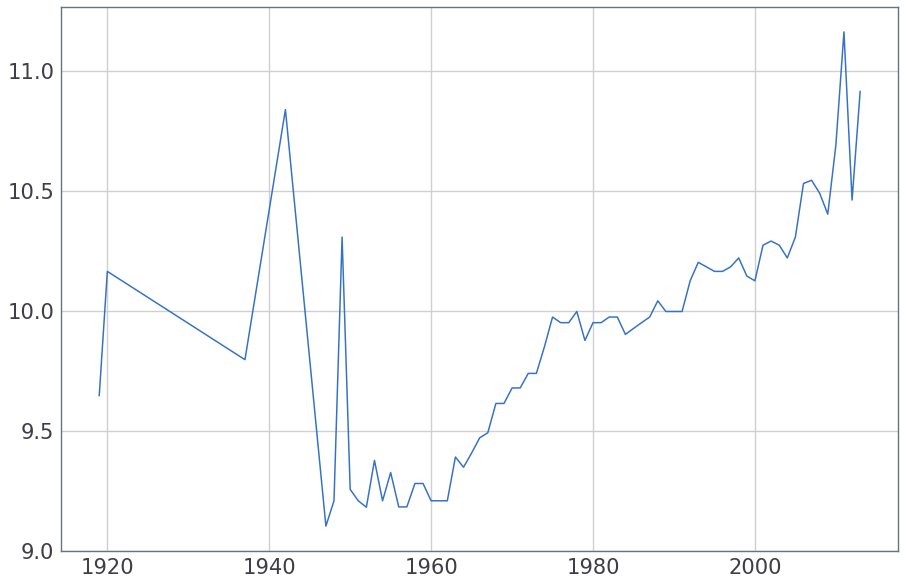

In [61]:
plot(*list(zip(*price_year)))

If that was unclear, let's plot the whole thing out

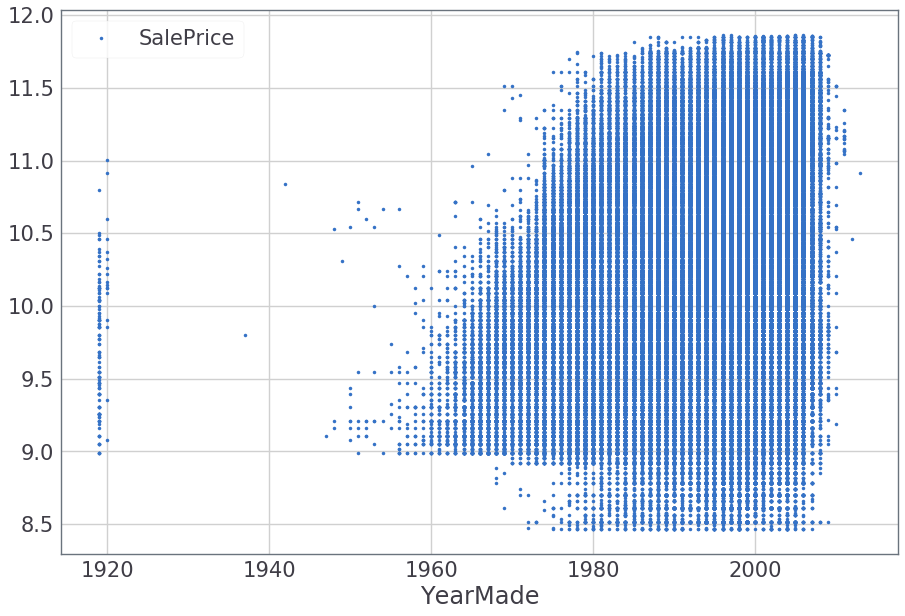

In [62]:
data[data.YearMade > 1800].plot('YearMade', 'SalePrice', style='.')

1. Something is driving the 1920s prices really high!

2. There is lack of sales data betwen 1920 and 1940.

3. There's only a couple of points around 1940.

4. After 1960, the price follows a predictable upward trend.

5. Many Low-Cost models were made after 1960

## SaleDate

In [ ]:
price_year = [(x, data[data.saleYear == x].SalePrice.median())
              for x in np.sort(data.saleYear.unique())]

In [ ]:
plot(*list(zip(*price_year)))

In [ ]:
data.plot('saleYear', 'SalePrice', style='.')

## Coupler_System

In [ ]:
# By what factor does the cardinality reduce when Coupler_System is one particular number?
sum([(x.nunique() / x[x.Coupler_System == i].nunique())
 for i in x.Coupler_System.unique()]).sort_values(ascending=False)

Turns out that Coupler_System may be highly correlated with the type of machine!

## High Cardinality, Low Importance Columns

In [63]:
data = data[to_keep]

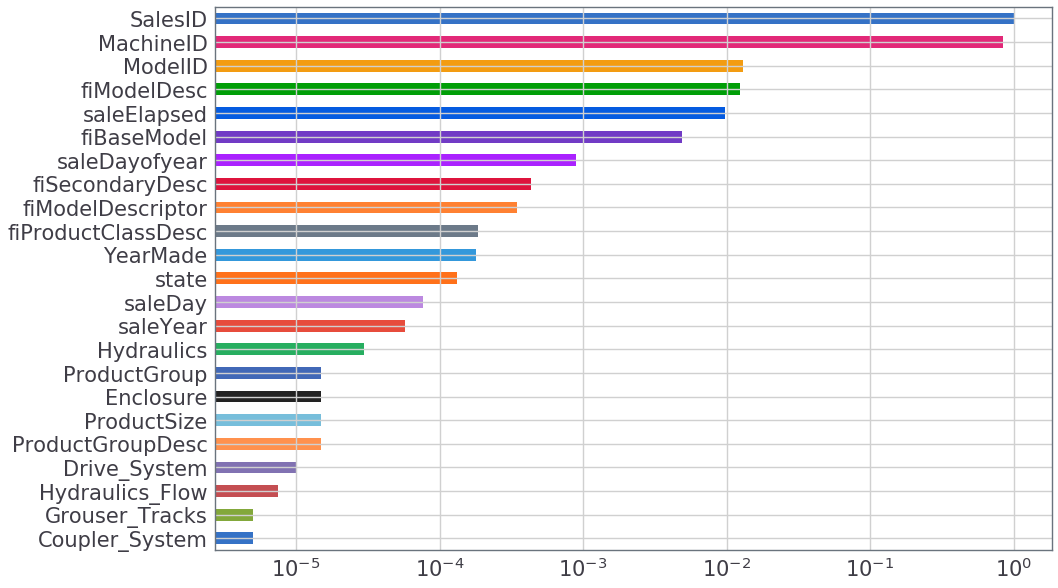

In [64]:
(data.nunique() / len(data)).sort_values().plot(kind='barh', logx=True) # Cardinality

Importance

In [70]:
fi = fi.T
fi.columns = fi.iloc[0].values
fi.drop('cols', inplace=True)

In [71]:
def draw_weighted_card(dilution=fi.T.imp.max()):
    ax = (data.nunique() / len(data)).sort_index().plot(kind='barh', logx=True, color='b', label='card')
    (fi.T / dilution).sort_index().plot(kind='barh', logx=True, color='r', label='fi', ax=ax, alpha=0.5)
    plt.legend()
    plt.title(f'Dilution: {dilution:.2f}')
    plt.show()

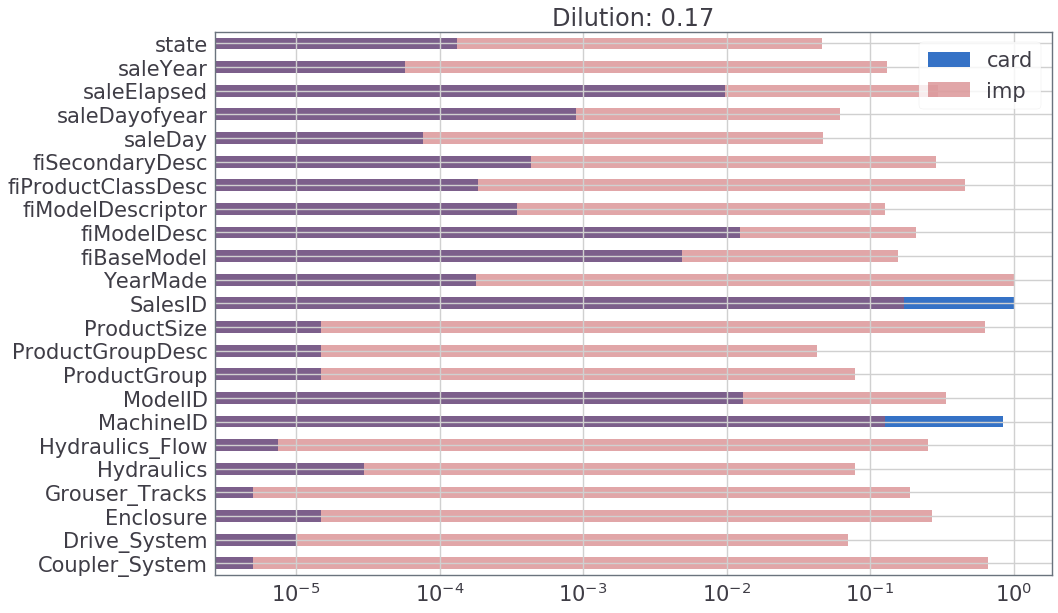

In [72]:
draw_weighted_card()

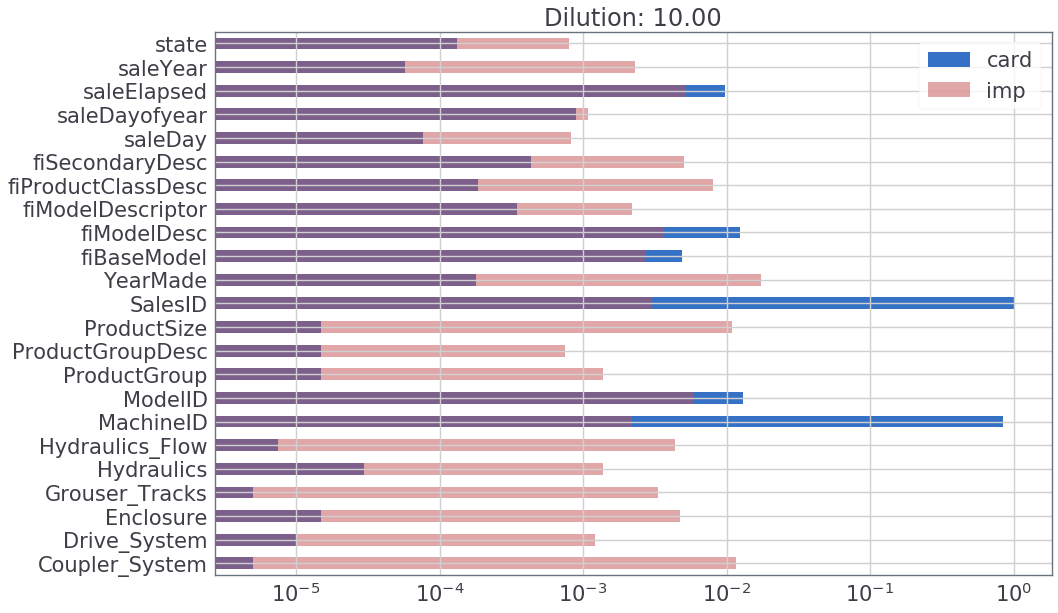

In [73]:
draw_weighted_card(dilution=10)

1. SalesID seems to be unique for each sale and therefore should be entirely omitted.

2. Machine ID/Model ID is very highly cardinal yet it's not dismissable.

3. Sub-Descriptions like Coupler_System, Drive_System, Enclosure, Grouser_Tracks, Hydraulics_Flow, Product_Size, Product_Group, Tire_Size, Track_Type are low-cardinality yet important enough. Can't be dismissed.

4. The fi* columns are moderately cardinal and important. However, the information may be contained within the other columns.

In [74]:
# By what factor does the cardinality reduce when fiBaseModel is one particular number?
sum([data[data.fiBaseModel == i].nunique() / data.nunique()
     for i in data.fiBaseModel.unique()]).sort_values() / data.fiBaseModel.nunique()

SalesID               0.000513
fiBaseModel           0.000513
ModelID               0.000513
fiModelDesc           0.000513
MachineID             0.000520
fiModelDescriptor     0.002450
fiSecondaryDesc       0.005316
fiProductClassDesc    0.017505
saleElapsed           0.023529
Drive_System          0.054359
Hydraulics_Flow       0.071966
YearMade              0.099131
Grouser_Tracks        0.116410
ProductSize           0.119316
Coupler_System        0.129744
saleDayofyear         0.131037
Hydraulics            0.141538
ProductGroup          0.179231
ProductGroupDesc      0.179231
state                 0.251350
Enclosure             0.311709
saleYear              0.330769
saleDay               0.446551
dtype: float64

As expected, the fiBaseModel seems to be a one-one mapping to the `ModelID` and `fiModelDesc`.

Further descriptions 
The MachineID also seems to be strongly correlated to these columns.

In [79]:
data = feather.read_dataframe(DIR_DATA / 'train.ft')

In [80]:
data.fiProductClassDesc.unique(), data.Engine_Horsepower.unique()

([Track Type Tractor, Dozer - 105.0 to 130.0 Hor..., Backhoe Loader - 14.0 to 15.0 Ft Standard Digg..., Motorgrader - 130.0 to 145.0 Horsepower, Wheel Loader - 175.0 to 200.0 Horsepower, Wheel Loader - 120.0 to 135.0 Horsepower, ..., Skid Steer Loader - 1751.0 to 2201.0 Lb Operat..., Skid Steer Loader - 2701.0+ Lb Operating Capacity, Wheel Loader - 1000.0 + Horsepower, Hydraulic Excavator, Track - 300.0 + Metric Tons, Motorgrader - Unidentified]
 Length: 74
 Categories (74, object): [Backhoe Loader - 0.0 to 14.0 Ft Standard Diggi... < Backhoe Loader - 14.0 to 15.0 Ft Standard Digg... < Backhoe Loader - 15.0 to 16.0 Ft Standard Digg... < Backhoe Loader - 16.0 + Ft Standard Digging Depth ... Wheel Loader - 60.0 to 80.0 Horsepower < Wheel Loader - 80.0 to 90.0 Horsepower < Wheel Loader - 90.0 to 100.0 Horsepower < Wheel Loader - Unidentified],
 [NaN, No, Variable]
 Categories (2, object): [No < Variable])

For example, `fiProductClassDesc` contains the information already in `Engine_Horsepower`.

In [ ]:
for f in fi.cols.values:
    if f not in data.columns or not hasattr(data[f], 'cat'): continue
    print(f, data[f].cat.categories)